In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
from phidl import CrossSection
from phidl import Path
import phidl.geometry as pg
import phidl.routing as pr
import phidl.path as pp
import pprint

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
from qubit_templates import *

In [3]:
# gap between two capacitance pads
gap_width = 20
JJtype = "dl" # mh or dl (manhattan or dolan)
Squid = True
Bandage = True

outname = "waferdesign_3D_" + JJtype
if Bandage:
    outname += "bd" 

# Wafer design

In [4]:
wafer = device_Wafer(inch = 4)

# Chip design

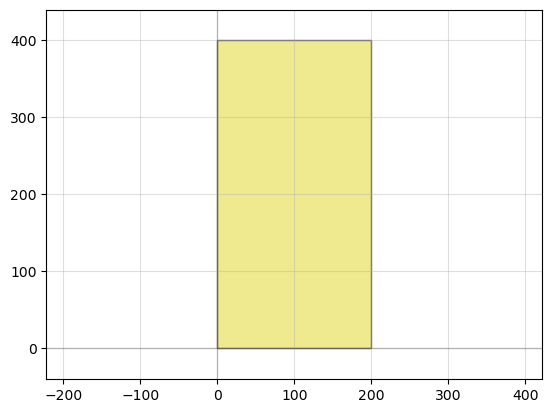

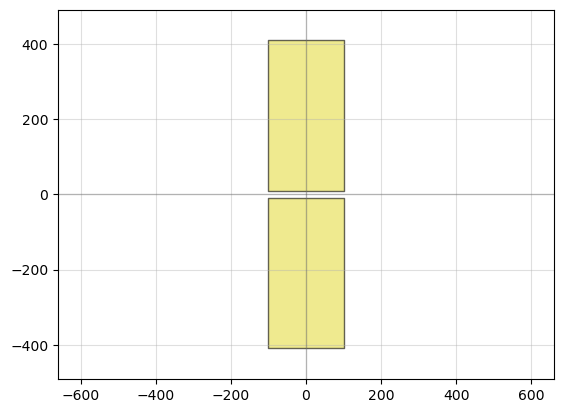

In [5]:
chipdesign = Device('chipdesign')

PAD=Device('PAD')
rectangle = pg.rectangle((200, 400), 3)
qp(rectangle)
PAD.add_ref( rectangle ).movex(0).movey(0.5*gap_width)
PAD.add_ref( rectangle ).mirror(p1 = (0, 0), p2 = (200, 0)).movex(0).movey(-0.5*gap_width)
PAD.center = (0, 0)

chipdesign.add_ref(PAD)
# Quickplot the imported design
qp(chipdesign)

# Josephson Junction

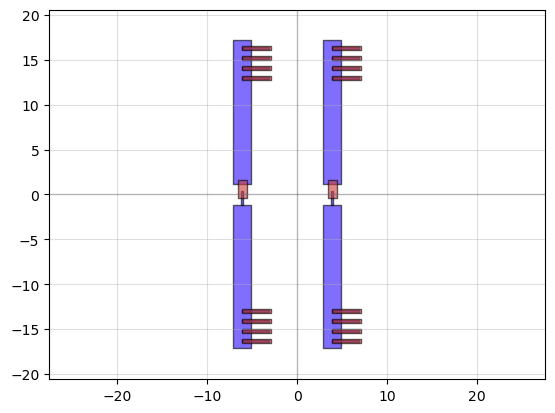

In [6]:
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = True, bandage = False)
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = False, bandage = False)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = True, bandage = True)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = False, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = False)
JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = True)
qp(JJ)


# Add JJ to chip design

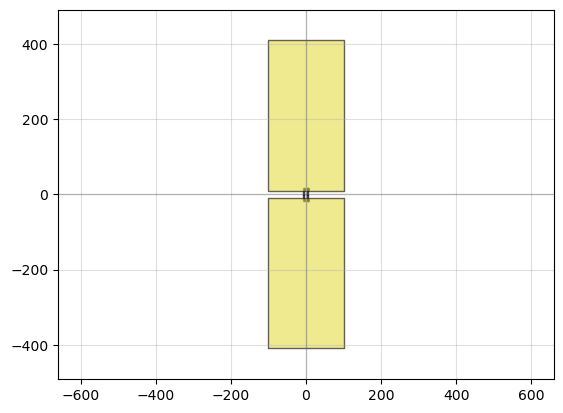

'output/chipdesign_3D.gds'

In [7]:
def custom_chip(width, height):
    chip = Device('chip')
    chip.add_ref(chipdesign)

    JJ = device_JJ(width = width, JJtype = JJtype, squid = Squid , bandage = Bandage)
    EBLine = device_EBLine()

    chip.add_ref(JJ)

    return chip

chip = custom_chip(width = 1.0, height = None)
qp(chip)
chip.write_gds('output/chipdesign_3D')

# Place chip designs

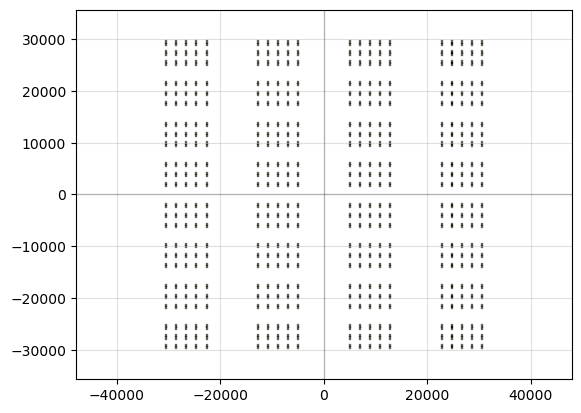

In [8]:
def custom_design(width, height):
    D = pg.gridsweep(
        function = custom_chip,
        param_x = {'width' :  [0.6, 0.7, 0.8, 0.9, 1.0]},
        param_y = {'height' : [10, 10, 10]},
        spacing = (1750, 1100),
        label_layer = None
        )
    D.center = (0,0)
    return D

design = pg.gridsweep(
        function = custom_design,
        param_x = {'width' :  [0.6, 0.7, 0.8, 0.9]},
        param_y = {'height' : [10, 10, 10, 10, 10, 10, 10, 10]},
        spacing = (9750, 3170),
        label_layer = None
        )
design.center = (0,0)
wafer.add_ref(design)
qp(design)


# Add EB markers

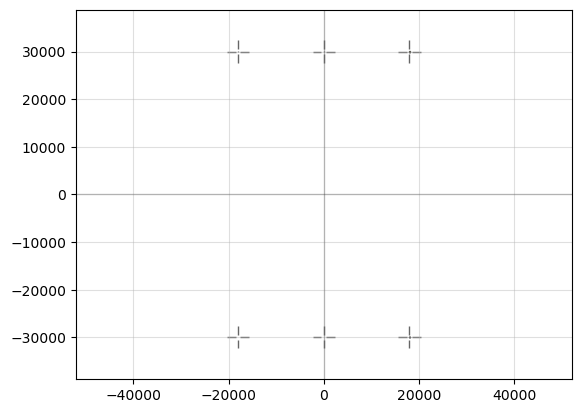

DeviceReference (parent Device "EBmarkers", ports [], origin (0, 0), rotation 0, x_reflection False)

In [9]:
marker_pos = [(0,30000),(18000,30000),(-18000,30000),
              (0,-30000),(18000,-30000),(-18000,-30000)]
EBmarkers = device_EBmarkers(marker_pos = marker_pos, layer = 3)
qp(EBmarkers)
wafer.add_ref(EBmarkers)


In [10]:
wafer.write_gds('output/' + outname)

'output/waferdesign_3D_dlbd.gds'